In [1]:
import os
import sys
import json
import time
import psutil
import threading
import contextlib
from pathlib import Path
from datetime import datetime

import pynvml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numba import cuda
from tqdm.auto import tqdm

C:\Users\looxx\AppData\Local\Temp\ipykernel_6324\194278581.py:11: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [2]:
# Add project src to sys.path for imports
root = os.path.abspath('.')
src_path = os.path.join(root, 'mcts_numba_cuda-main', 'src')

if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [3]:
from c4 import C4
from mctsnc import MCTSNC

In [4]:
if cuda.is_available():
    dev = cuda.get_current_device()
    print('CUDA device name:', dev.name)
else:
    print('CUDA is not available.')

CUDA device name: b'NVIDIA GeForce GTX 1650'


In [5]:
# Directories for outputs
results_dir = Path("results")
plots_dir = Path("plots")
results_dir.mkdir(exist_ok=True)
plots_dir.mkdir(exist_ok=True)

In [6]:
# Helpers
def _to_jsonable(obj):
    """
    Convert common nested Python / array-like objects into JSON-serializable types.
    """
    if isinstance(obj, dict):
        return {k: _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [_to_jsonable(v) for v in obj]
    return obj


def run_trials(n_trees, n_playouts, trials=5, forced_search_steps_limit=5, seed_base=0, verbose=False, progress=True, resume=True, search_time_limit=None):
    """
    Run `trials` independent experiments for given configuration and save per-trial JSONs.
    Returns list of per-trial dict summaries (including already-existing trials when resuming).
    """
    trial_results = []
    iterator = range(trials)
    if progress:
        iterator = tqdm(range(trials), desc=f"trials nt={n_trees} np={n_playouts}", leave=False)
    for t in iterator:
        seed = int(seed_base + t)
        fname = results_dir / f"ocp_thrifty_ntrees-{n_trees}_nplayouts-{n_playouts}_trial-{t}.json"
        if resume and fname.exists():
            # load existing result and skip
            try:
                with open(fname, 'r') as f:
                    data = json.load(f)
                    trial = data.get('trial', None) or data
                    trial_results.append(trial)
                if verbose:
                    print(f"Skipping existing {fname}")
                continue
            except Exception as e:
                print(f"Warning: failed to load {fname}, will re-run trial (error: {e})")
        # create the AI with optional search_time_limit (only pass it when not None to avoid validation error)
        mcts_kwargs = dict(variant='ocp_thrifty', n_trees=n_trees, n_playouts=n_playouts, seed=seed,
                           verbose_info=False, verbose_debug=False, action_index_to_name_function=C4.action_index_to_name)
        if search_time_limit is not None:
            mcts_kwargs['search_time_limit'] = search_time_limit
        ai = MCTSNC(C4.get_board_shape(), C4.get_extra_info_memory(), C4.get_max_actions(), **mcts_kwargs)

        # initialize device-side arrays and run while optionally suppressing prints
        if verbose:
            ai.init_device_side_arrays()
            start_time = time.time()
            best_action = ai.run(C4().get_board(), C4().get_extra_info(), C4().get_turn(), forced_search_steps_limit=forced_search_steps_limit)
        else:
            with open(os.devnull, 'w') as devnull:
                with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
                    ai.init_device_side_arrays()
                    start_time = time.time()
                    best_action = ai.run(C4().get_board(), C4().get_extra_info(), C4().get_turn(), forced_search_steps_limit=forced_search_steps_limit)
        elapsed = ai.time_total

        perf = ai._make_performance_info()
        actions = ai._make_actions_info_thrifty()
        best_entry = actions.get('best', None)

        trial = {
            'n_trees': int(n_trees),
            'n_playouts': int(n_playouts),
            'trial': int(t),
            'seed': int(seed),
            'best_action': int(best_action),
            'best_q': float(best_entry['q']) if best_entry else None,
            'best_n': int(best_entry['n']) if best_entry else None,
            'best_n_wins': int(best_entry['n_wins']) if best_entry else None,
            'time_total': float(elapsed),
            'steps': int(ai.steps),
            'playouts': int(perf.get('playouts', np.nan)),
            'playouts_per_second': float(perf.get('playouts_per_second', np.nan)),
            **{f"times_{k}": float(v) for k, v in perf.get('times_[ms]', {}).items()}
        }

        saved = {
            'config': {'n_trees': n_trees, 'n_playouts': n_playouts, 'trial': t, 'seed': seed},
            'trial': trial,
            'meta': {'saved_at': time.strftime('%Y-%m-%dT%H:%M:%S')}
        }
        with open(fname, 'w') as f:
            json.dump(_to_jsonable(saved), f, indent=2)

        trial_results.append(trial)
        if verbose:
            print(f"Saved {fname}: best_action={trial['best_action']} best_q={trial['best_q']} playouts/s={trial['playouts_per_second']}")
    return trial_results

In [7]:
def get_gpu_handle():
    try:
        pynvml.nvmlInit()
        return pynvml.nvmlDeviceGetHandleByIndex(0)
    except Exception:
        return None

class Monitor(threading.Thread):
    def __init__(self, delay=0.1, logfile="results/monitoring_log.csv"):
        super().__init__()
        self.stopped = threading.Event()
        self.delay = delay
        self.logfile = Path(logfile)
        self.gpu_handle = get_gpu_handle()
        self.process = psutil.Process()
        self.data = []

    def run(self):
        self.logfile.parent.mkdir(parents=True, exist_ok=True)
        while not self.stopped.is_set():
            metrics = self.sample()
            self.data.append(metrics)
            time.sleep(self.delay)
        
        if self.data:
            df = pd.DataFrame(self.data)
            df.to_csv(self.logfile, index=False)

    def sample(self):
        m = {'timestamp': datetime.utcnow().isoformat()}
        try:
            m['cpu_percent'] = psutil.cpu_percent()
            m['rss_mb'] = self.process.memory_info().rss / (1024*1024)
            if self.gpu_handle:
                util = pynvml.nvmlDeviceGetUtilizationRates(self.gpu_handle)
                mem = pynvml.nvmlDeviceGetMemoryInfo(self.gpu_handle)
                m['gpu_util_percent'] = util.gpu
                m['gpu_mem_used_mb'] = mem.used / (1024*1024)
        except Exception as e:
            m['error'] = str(e)
        return m

    def stop(self):
        self.stopped.set()

In [8]:
grid_n_trees = [1, 4, 8, 16]
grid_n_playouts = [32, 64, 128, 256, 512]
trials_per_config = 100
forced_steps = 20
search_time_limit = None 

all_rows = []
configs = [(nt, np_) for nt in grid_n_trees for np_ in grid_n_playouts]

# Start monitoring
monitor = Monitor(delay=0.2)
monitor.start()

try:
    for config_idx, (nt, np_) in enumerate(tqdm(configs, desc="configs", total=len(configs)), start=1):
        print(f"[{config_idx}/{len(configs)}] Running config: n_trees={nt}, n_playouts={np_} ({trials_per_config} trials)", flush=True)
        rows = run_trials(nt, np_, trials=trials_per_config, forced_search_steps_limit=forced_steps, seed_base=1000, verbose=False, progress=False, resume=False, search_time_limit=search_time_limit)
        all_rows.extend(rows)
        
        config_df = pd.DataFrame(rows)
        mean_playouts_per_second = config_df['playouts_per_second'].mean() if not config_df.empty else np.nan
        mean_best_q = config_df['best_q'].mean() if not config_df.empty else np.nan
        print(f"[{config_idx}/{len(configs)}] Completed: n_trees={nt}, n_playouts={np_} - playouts/s={mean_playouts_per_second:.0f}, mean_best_q={mean_best_q:.4f}", flush=True)
finally:
    # Stop monitoring
    monitor.stop()
    monitor.join()

C:\Users\looxx\AppData\Local\Temp\ipykernel_6324\3072625990.py:30: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  m = {'timestamp': datetime.utcnow().isoformat()}


configs:   0%|          | 0/20 [00:00<?, ?it/s]

[1/20] Running config: n_trees=1, n_playouts=32 (100 trials)
[1/20] Completed: n_trees=1, n_playouts=32 - playouts/s=25593, mean_best_q=0.6496
[2/20] Running config: n_trees=1, n_playouts=64 (100 trials)
[2/20] Completed: n_trees=1, n_playouts=64 - playouts/s=52265, mean_best_q=0.6416
[3/20] Running config: n_trees=1, n_playouts=128 (100 trials)
[3/20] Completed: n_trees=1, n_playouts=128 - playouts/s=100643, mean_best_q=0.6356
[4/20] Running config: n_trees=1, n_playouts=256 (100 trials)
[4/20] Completed: n_trees=1, n_playouts=256 - playouts/s=185010, mean_best_q=0.6337
[5/20] Running config: n_trees=1, n_playouts=512 (100 trials)
[5/20] Completed: n_trees=1, n_playouts=512 - playouts/s=350306, mean_best_q=0.6399
[6/20] Running config: n_trees=4, n_playouts=32 (100 trials)
[6/20] Completed: n_trees=4, n_playouts=32 - playouts/s=101651, mean_best_q=0.6407
[7/20] Running config: n_trees=4, n_playouts=64 (100 trials)
[7/20] Completed: n_trees=4, n_playouts=64 - playouts/s=212774, mean_be

In [9]:
# Aggregate results from all JSON files in results_dir (resumable & robust)
all_files = sorted(results_dir.glob('ocp_thrifty_ntrees-*_nplayouts-*_trial-*.json'))
rows = []
for f in all_files:
    with open(f, 'r') as fh:
        d = json.load(fh)
        trial = d.get('trial', None) or d
        rows.append(trial)

df = pd.DataFrame(rows)
summary_csv = results_dir / "ocp_thrifty_summary.csv"
df.to_csv(summary_csv, index=False)

In [10]:
summary = df.groupby(['n_trees', 'n_playouts']).agg(
    mean_playouts_per_second=('playouts_per_second', 'mean'),
    std_playouts_per_second=('playouts_per_second', 'std'),
    mean_best_q=('best_q', 'mean'),
    std_best_q=('best_q', 'std')
).reset_index()

In [11]:
# Plotting
sns.set_theme(style="whitegrid")
summary = df.groupby(["n_trees", "n_playouts"]).agg(
mean_playouts_per_second=("playouts_per_second", "mean"),
std_playouts_per_second=("playouts_per_second", "std"),
mean_best_q=("best_q", "mean"),
std_best_q=("best_q", "std")
).reset_index()

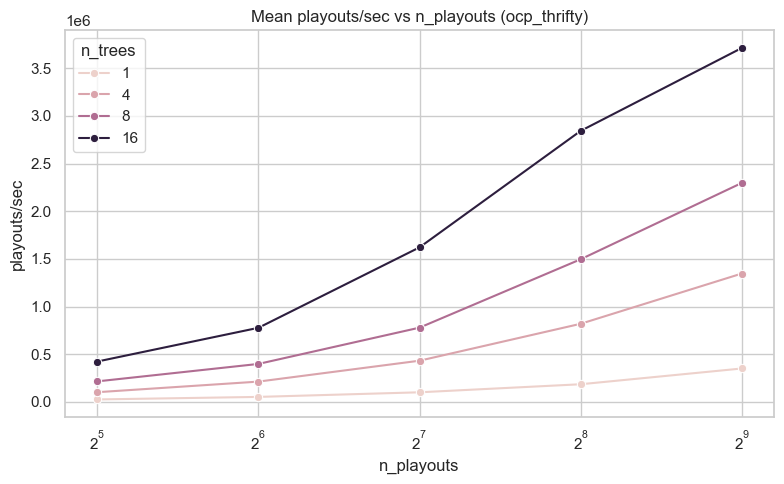

In [12]:
# playouts/sec
plt.figure(figsize=(8, 5))
sns.lineplot(data=summary, x="n_playouts", y="mean_playouts_per_second", hue="n_trees", marker="o")
plt.title("Mean playouts/sec vs n_playouts (ocp_thrifty)")
plt.xlabel("n_playouts")
plt.ylabel("playouts/sec")
plt.xscale("log", base=2)
plt.tight_layout()
plt.savefig(plots_dir / "playouts_per_second_vs_n_playouts.png")

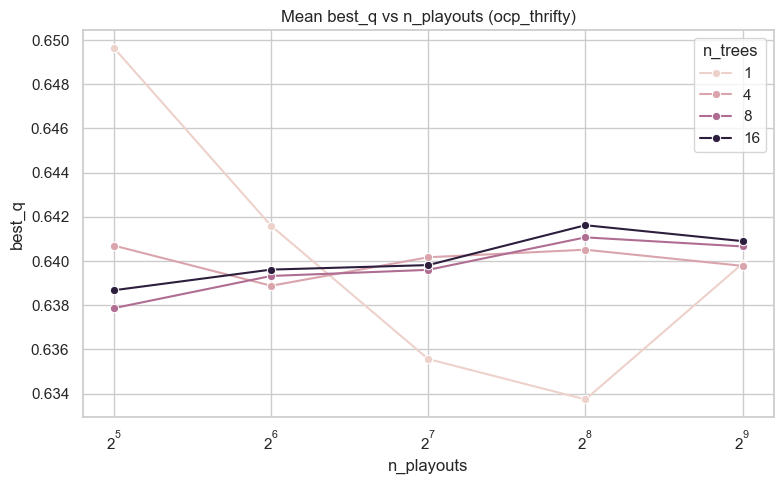

In [13]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=summary, x="n_playouts", y="mean_best_q", hue="n_trees", marker="o")
plt.title("Mean best_q vs n_playouts (ocp_thrifty)")
plt.xlabel("n_playouts")
plt.ylabel("best_q")
plt.xscale("log", base=2)
plt.tight_layout()
plt.savefig(plots_dir / "best_q_vs_n_playouts.png")

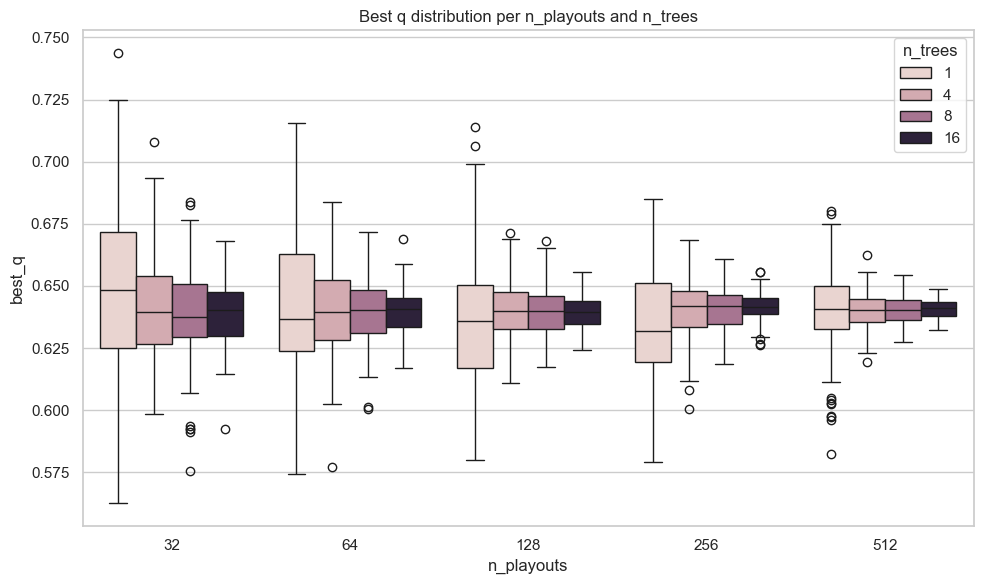

In [14]:
# boxplot (treat `n_playouts` as categorical; do NOT use log scale on categorical axis)
plt.figure(figsize=(10, 6))
order = sorted(df['n_playouts'].unique())
sns.boxplot(data=df, x="n_playouts", y="best_q", hue="n_trees", order=order)
plt.title("Best q distribution per n_playouts and n_trees")
plt.xlabel("n_playouts")
plt.ylabel("best_q")
plt.tight_layout()
plt.savefig(plots_dir / "best_q_boxplot.png")

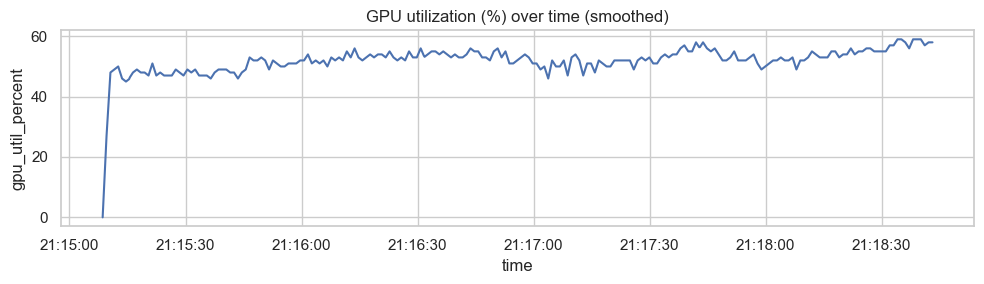

In [ ]:
# Load and visualize monitoring logs (to be run after instrumented experiments)
mon_file = Path('results/monitoring_log.csv')
df_mon = pd.read_csv(mon_file)
plt.figure(figsize=(10, 3))
plt.plot(pd.to_datetime(df_mon['timestamp']), df_mon['gpu_util_percent'].rolling(5).mean())
plt.title('GPU utilization (%) over time (smoothed)')
plt.xlabel('time')
plt.ylabel('gpu_util_percent')
plt.tight_layout()
plt.savefig(plots_dir / "gpu_utilization_over_time.png")